In [3]:
# Install kagglehub (only needed once per session)
!pip install -q kagglehub

# Download the COCO 2017 dataset using kagglehub (public version)
import kagglehub
coco_path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

# Check what's inside the downloaded COCO path
import os
print("Downloaded to:", coco_path)
print("Contents:", os.listdir(coco_path))


Downloaded to: /kaggle/input/coco-2017-dataset
Contents: ['coco2017']


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.models import Model
import os

# COCO-style image folder
image_folder = "/content/coco2017/images/train2017"  # adjust path if needed
print("Loading images from:", image_folder)

# CNN encoder: VGG16 (exclude top layers), output flattened feature maps
base_model = VGG16(weights='imagenet', include_top=False)
base_model.trainable = False

# Build the encoder model
cnn_input = Input(shape=(224, 224, 3))
cnn_out = base_model(cnn_input)                             # Output shape: (None, 7, 7, 512)
cnn_out = Reshape((7*7, 512))(cnn_out)                      # Flatten to: (None, 49, 512)
cnn_encoder = Model(inputs=cnn_input, outputs=cnn_out)
cnn_encoder.summary()


Loading images from: /content/coco2017/images/train2017
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 512)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
import json

# COCO 2017 captions path
caption_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# Step 1: Read and inspect the JSON structure
with open(caption_path, 'r') as f:
    coco_captions = json.load(f)

# Step 2: Check top-level keys
print("Top-level keys:", coco_captions.keys())

# Step 3: Print first 5 annotations (captions)
print("\nFirst 5 captions:")
for item in coco_captions['annotations'][:5]:
    print(f"Image ID: {item['image_id']}, Caption: {item['caption']}")


Top-level keys: dict_keys(['info', 'licenses', 'images', 'annotations'])

First 5 captions:
Image ID: 203564, Caption: A bicycle replica with a clock as the front wheel.
Image ID: 322141, Caption: A room with blue walls and a white sink and door.
Image ID: 16977, Caption: A car that seems to be parked illegally behind a legally parked car
Image ID: 106140, Caption: A large passenger airplane flying through the air.
Image ID: 106140, Caption: There is a GOL plane taking off in a partly cloudy sky.


In [6]:
import json
import tensorflow as tf

# Step 1: Load COCO caption annotations
caption_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"
with open(caption_path, 'r') as f:
    coco_data = json.load(f)

# Step 2: Extract and wrap captions
captions = [f"<start> {ann['caption'].strip()} <end>" for ann in coco_data['annotations'] if ann['caption'].strip()]

# Sanity check
if not captions:
    raise ValueError("No captions found – check formatting or dataset structure.")

# Step 3: Vectorization
max_len = 40
vectorizer = tf.keras.layers.TextVectorization(
    output_mode='int',
    output_sequence_length=max_len
)
vectorizer.adapt(captions)

# Step 4: Vocabulary and sequences
vocab = vectorizer.get_vocabulary()
sequences = vectorizer(tf.constant(captions))

# Step 5: Inspect
print("✅ Total captions loaded:", len(captions))
print("🧠 Vocabulary size:", len(vocab))
print("🔢 Example sequence (IDs):", sequences[0].numpy())
print("📝 Decoded sequence (words):",
      [vocab[i] for i in sequences[0].numpy() if i < len(vocab)])


✅ Total captions loaded: 591753
🧠 Vocabulary size: 29077
🔢 Example sequence (IDs): [   4    2  354 3807    9    2   83  122    7   40 1083    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
📝 Decoded sequence (words): [np.str_('start'), np.str_('a'), np.str_('bicycle'), np.str_('replica'), np.str_('with'), np.str_('a'), np.str_('clock'), np.str_('as'), np.str_('the'), np.str_('front'), np.str_('wheel'), np.str_('end'), '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1) Token + Positional Embedding
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb   = layers.Embedding(input_dim=max_len, output_dim=embed_dim)
    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return token_embedding + pos_embedding

# 2) Transformer Encoder Layer (only self-attention)
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn_dim, dropout_rate=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim//num_heads,
                                             dropout=dropout_rate)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ffn_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training):
        # Self-attention
        attn_output = self.mha(x, x, x, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(x + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

# 3) Transformer Decoder Layer (masked self-att + cross-attention)
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim, num_heads, ffn_dim, max_len, dropout_rate=0.1):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(vocab_size, embed_dim, max_len)
        self.self_att  = layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim//num_heads,
                                                   dropout=dropout_rate)
        self.cross_att = layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim//num_heads,
                                                   dropout=dropout_rate)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ffn_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)
        self.final_dense = layers.Dense(vocab_size, activation='softmax')

    def _causal_mask(self, seq_len):
        # lower triangular matrix
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return mask  # shape (seq_len, seq_len)

    def call(self, x, enc_output, training):
        # x: (batch, tgt_seq_len), enc_output: (batch, enc_seq_len, embed_dim)
        x = self.embedding(x)  # add token + positional embeddings
        seq_len = tf.shape(x)[1]
        causal_mask = self._causal_mask(seq_len)

        # 1) Masked self-attention
        attn1 = self.self_att(x, x, x, attention_mask=causal_mask, training=training)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.norm1(x + attn1)

        # 2) Cross-attention to encoder output
        attn2 = self.cross_att(out1, enc_output, enc_output, training=training)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.norm2(out1 + attn2)

        # 3) Feed-forward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.norm3(out2 + ffn_output)

        # 4) Final linear + softmax
        return self.final_dense(out3)

# 4) Full ImageCaptioningModel integrating CNN encoder + Transformer
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_encoder, transformer_encoder, transformer_decoder):
        super().__init__()
        self.cnn_encoder = cnn_encoder
        self.transformer_encoder = transformer_encoder
        self.transformer_decoder = transformer_decoder

        # Loss & metrics
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,
                                                                     reduction='none')
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.acc_tracker  = tf.keras.metrics.Mean(name='accuracy')

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    def _compute_loss_and_acc(self, y_true, y_pred):
        # y_true, y_pred: (batch, seq_len)
        mask = tf.cast(y_true != 0, tf.float32)
        loss = self.loss_fn(y_true, y_pred)
        loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
        # Accuracy
        pred_ids = tf.argmax(y_pred, axis=-1)
        acc = tf.cast(pred_ids == y_true, tf.float32)
        acc = tf.reduce_sum(acc * mask) / tf.reduce_sum(mask)
        return loss, acc

    def train_step(self, data):
        images, captions = data  # captions includes start+end tokens
        with tf.GradientTape() as tape:
            # 1) CNN features
            img_feat = self.cnn_encoder(images, training=False)
            # 2) Transformer encoder
            enc_out = self.transformer_encoder(img_feat, training=True)
            # 3) Prepare decoder input & target
            dec_input = captions[:, :-1]
            dec_target = captions[:, 1:]
            # 4) Transformer decoder output
            y_pred = self.transformer_decoder(dec_input, enc_out, training=True)
            # 5) Loss & acc
            loss, acc = self._compute_loss_and_acc(dec_target, y_pred)

        # 6) Backprop
        trainable_vars = (self.transformer_encoder.trainable_variables +
                          self.transformer_decoder.trainable_variables)
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # 7) Update metrics
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {'loss': self.loss_tracker.result(), 'accuracy': self.acc_tracker.result()}

    def test_step(self, data):
        images, captions = data
        img_feat = self.cnn_encoder(images, training=False)
        enc_out = self.transformer_encoder(img_feat, training=False)
        dec_input = captions[:, :-1]
        dec_target = captions[:, 1:]
        y_pred = self.transformer_decoder(dec_input, enc_out, training=False)
        loss, acc = self._compute_loss_and_acc(dec_target, y_pred)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {'loss': self.loss_tracker.result(), 'accuracy': self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

# 5) Instantiate and compile
embed_dim = 512
ffn_dim   = 512
num_heads = 8
vocab_size = len(vocab)

transformer_encoder = TransformerEncoder(embed_dim, num_heads, ffn_dim, dropout_rate=0.1)
transformer_decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, ffn_dim, max_len, dropout_rate=0.1)

caption_model = ImageCaptioningModel(
    cnn_encoder=cnn_encoder,
    transformer_encoder=transformer_encoder,
    transformer_decoder=transformer_decoder
)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4)
)

# Ready for training:
# caption_model.fit(train_dataset, epochs=12, validation_data=val_dataset)


In [ ]:
import os
import json
import collections
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files

# Step 1: Set image folder and annotation path
image_folder = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# Step 2: Load and parse COCO captions
with open(annotation_path, 'r') as f:
    coco_data = json.load(f)

captions = []
image_ids = []

for ann in coco_data['annotations']:
    cap = ann['caption'].strip()
    if cap:
        captions.append(f"<start> {cap} <end>")
        # COCO image filenames are zero-padded 12-digit IDs + ".jpg"
        image_ids.append(f"{ann['image_id']:012d}.jpg")

# Step 3: Vectorize the captions
max_len = 40
vectorizer = tf.keras.layers.TextVectorization(
    output_mode='int',
    output_sequence_length=max_len
)
vectorizer.adapt(captions)

vocab = vectorizer.get_vocabulary()
sequences = vectorizer(tf.constant(captions))

# Step 4: Map captions to images
caption_map = collections.defaultdict(list)
for img_name, seq in zip(image_ids, sequences.numpy()):
    caption_map[img_name].append(seq)

# Step 5: Build image paths and caption sequences
image_paths = []
caption_seqs = []

for img_name, seqs in caption_map.items():
    full_img_path = os.path.join(image_folder, img_name)
    for seq in seqs:
        image_paths.append(full_img_path)
        caption_seqs.append(seq)

# Step 6: Create tf.data pipeline
BATCH_SIZE = 64

def load_and_preprocess(image_path, cap_seq):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, cap_seq

dataset = tf.data.Dataset.from_tensor_slices((image_paths, caption_seqs))
dataset = dataset.shuffle(buffer_size=len(image_paths))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Step 7: Split train/val
total_batches = tf.data.experimental.cardinality(dataset).numpy()
val_batches = int(0.1 * total_batches)
val_dataset = dataset.take(val_batches)
train_dataset = dataset.skip(val_batches)

print("✅ Train batches:", tf.data.experimental.cardinality(train_dataset).numpy())
print("✅ Val   batches:", tf.data.experimental.cardinality(val_dataset).numpy())

# Step 8: Define training callbacks
EPOCHS = 15
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('image_captioning.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Step 9: Train the model
history = caption_model.fit(  # <-- make sure `caption_model` is defined
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# Step 10: Download the model (in Colab)
files.download('image_captioning.h5')


✅ Train batches: 570
✅ Val   batches: 63
Epoch 1/15

Epoch 1: val_loss improved from inf to 3.10310, saving model to image_captioning.h5


570/570 - 268s - 470ms/step - accuracy: 0.3211 - loss: 3.9040 - val_accuracy: 0.3848 - val_loss: 3.1031
Epoch 2/15

Epoch 2: val_loss improved from 3.10310 to 2.64260, saving model to image_captioning.h5


570/570 - 237s - 416ms/step - accuracy: 0.3961 - loss: 2.9932 - val_accuracy: 0.4307 - val_loss: 2.6426
Epoch 3/15

Epoch 3: val_loss improved from 2.64260 to 2.33761, saving model to image_captioning.h5


570/570 - 234s - 410ms/step - accuracy: 0.4322 - loss: 2.6420 - val_accuracy: 0.4740 - val_loss: 2.3376
Epoch 4/15

Epoch 4: val_loss improved from 2.33761 to 2.05278, saving model to image_captioning.h5


570/570 - 233s - 409ms/step - accuracy: 0.4636 - loss: 2.3879 - val_accuracy: 0.5095 - val_loss: 2.0528
Epoch 5/15

Epoch 5: val_loss improved from 2.05278 to 1.87679, saving model to image_captioning.h5


570/570 - 235s - 412ms/step - accuracy: 0.4887 - loss: 2.1795 - val_accuracy: 0.5362 - val_loss: 1.8768
Epoch 6/15

Epoch 6: val_loss improved from 1.87679 to 1.69105, saving model to image_captioning.h5


570/570 - 235s - 412ms/step - accuracy: 0.5138 - loss: 2.0030 - val_accuracy: 0.5716 - val_loss: 1.6911
Epoch 7/15

Epoch 7: val_loss improved from 1.69105 to 1.53463, saving model to image_captioning.h5


570/570 - 261s - 458ms/step - accuracy: 0.5383 - loss: 1.8507 - val_accuracy: 0.5999 - val_loss: 1.5346
Epoch 8/15

Epoch 8: val_loss improved from 1.53463 to 1.41001, saving model to image_captioning.h5


570/570 - 236s - 413ms/step - accuracy: 0.5587 - loss: 1.7238 - val_accuracy: 0.6242 - val_loss: 1.4100
Epoch 9/15

Epoch 9: val_loss improved from 1.41001 to 1.28550, saving model to image_captioning.h5


570/570 - 234s - 410ms/step - accuracy: 0.5809 - loss: 1.6042 - val_accuracy: 0.6491 - val_loss: 1.2855
Epoch 10/15

Epoch 10: val_loss improved from 1.28550 to 1.18104, saving model to image_captioning.h5


570/570 - 235s - 413ms/step - accuracy: 0.5984 - loss: 1.5046 - val_accuracy: 0.6762 - val_loss: 1.1810
Epoch 11/15

Epoch 11: val_loss improved from 1.18104 to 1.09869, saving model to image_captioning.h5


570/570 - 233s - 409ms/step - accuracy: 0.6162 - loss: 1.4151 - val_accuracy: 0.6920 - val_loss: 1.0987
Epoch 12/15

Epoch 12: val_loss improved from 1.09869 to 1.01796, saving model to image_captioning.h5


570/570 - 234s - 410ms/step - accuracy: 0.6335 - loss: 1.3323 - val_accuracy: 0.7124 - val_loss: 1.0180
Epoch 13/15

Epoch 13: val_loss improved from 1.01796 to 0.94768, saving model to image_captioning.h5


570/570 - 263s - 461ms/step - accuracy: 0.6484 - loss: 1.2574 - val_accuracy: 0.7276 - val_loss: 0.9477
Epoch 14/15

Epoch 14: val_loss improved from 0.94768 to 0.87656, saving model to image_captioning.h5


570/570 - 233s - 409ms/step - accuracy: 0.6619 - loss: 1.1959 - val_accuracy: 0.7467 - val_loss: 0.8766
Epoch 15/15

Epoch 15: val_loss improved from 0.87656 to 0.82162, saving model to image_captioning.h5


570/570 - 234s - 411ms/step - accuracy: 0.6749 - loss: 1.1341 - val_accuracy: 0.7622 - val_loss: 0.8216
Restoring model weights from the end of the best epoch: 15.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Loaded weights from image_captioning.h5


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


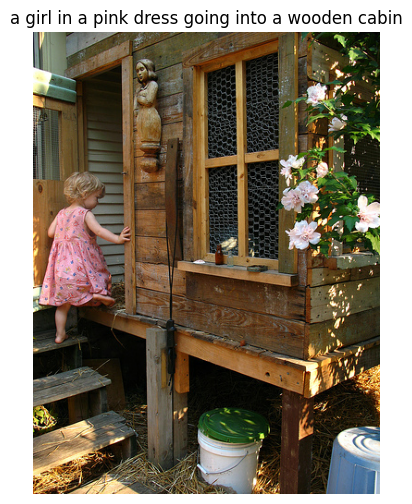

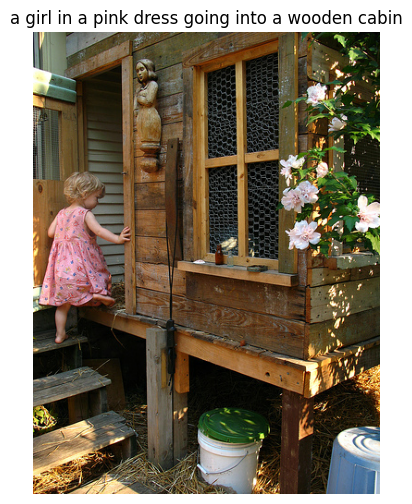

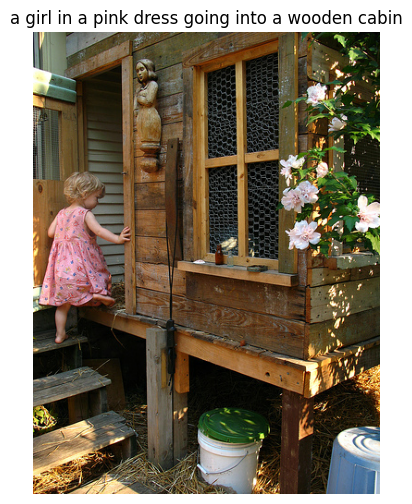

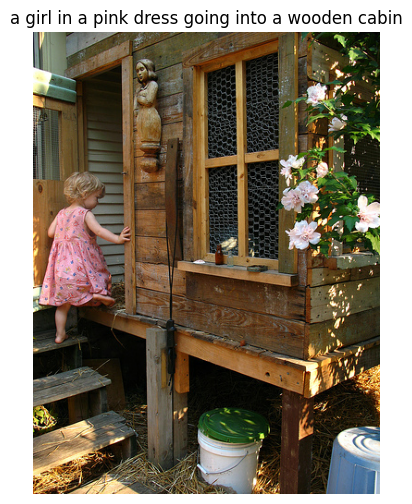

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 1) Load the best‐saved weights
caption_model.load_weights('image_captioning.h5')
print("✅ Loaded weights from image_captioning.h5")



✅ Loaded weights from 'image_captioning.h5'


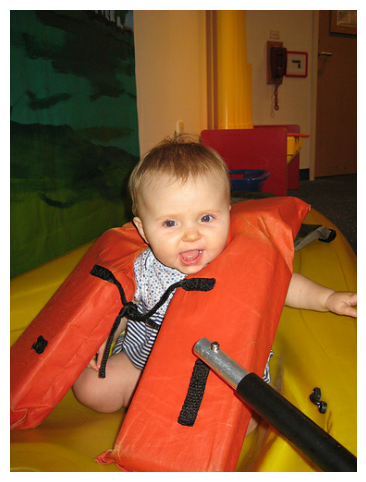

Image: 2615811117_42b1838205.jpg

Ground-truth captions:
  1. A baby in a life jacket on a raft .
  2. A baby is wearing an adult life jacket whilst sitting in a dinghy inside the house .
  3. A happy baby wears an orange life vest .
  4. A young kid wearing a life jacket
  5. The toddler sits in the boat with a life jacket on indoors .

Generated caption:
  → a happy baby wearing a life jacket on a red life jacket




Image: 2380740486_8cd5d4601a.jpg

Ground-truth captions:
  1. A girl and some ducks walk towards the water .
  2. A little girl is creeping behind two ducks at the top of a cliff overlooking the ocean .
  3. A person trails behind some ducks on the water to a lake .
  4. A woman walks after two geese near the ocean .
  5. Girl with two ducks on cliff overlooking the water .

Generated caption:
  → a woman walks two geese near the ocean




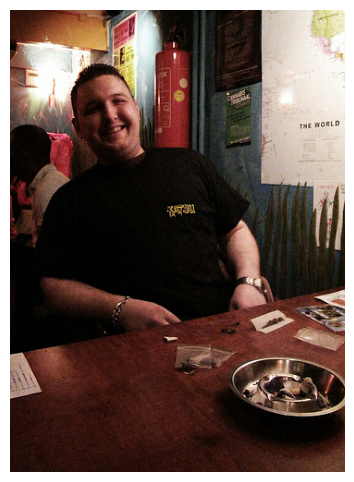

Image: 3066338314_2c3fb731d1.jpg

Ground-truth captions:
  1. A man in black is sitting in a restaurant .
  2. A man sits at a table .
  3. A man wearing a black shirt laughs while sitting at the table .
  4. A smiling man leaning back from a table with an ashtray on top .
  5. The man sitting at the table is posing for a picture .

Generated caption:
  → a man sits in a booth with his arm around a table




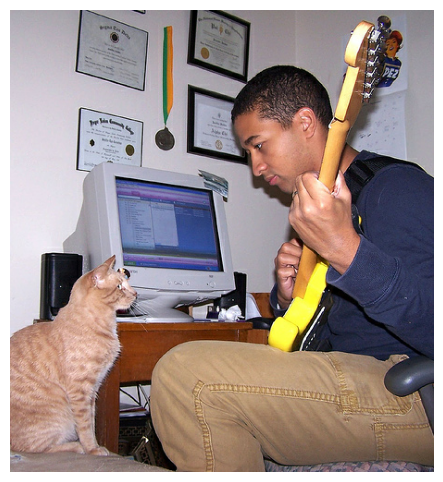

Image: 300222673_573fd4044b.jpg

Ground-truth captions:
  1. A man plays a song on the guitar for his cat .
  2. A man plays a yellow guitar while a cat watches him .
  3. A man plays his yellow guitar while staring at his cat .
  4. "A man , sitting by his computer , playing guitar to his cat ."
  5. The man is playing guitar and sitting with a cat .

Generated caption:
  → a man plays his yellow guitar and sitting at a cat




Image: 2313822078_282dc07531.jpg

Ground-truth captions:
  1. A child swings on his stomach on a tire swing amidst trees .
  2. A small child on a tire swing in a forested field .
  3. a small child playing on a tire swing
  4. a small kid swinging on a tire swing
  5. A very little child swings on a tire swing .

Generated caption:
  → a small child swings on a tire swing in the woods




In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Paths & constants ---
IMAGE_FOLDER = "/kaggle/input/flickr8k/Images"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"
WEIGHTS_FILE = "image_captioning.h5"    # your saved model
NUM_SAMPLES  = 5                        # how many images to display

# --- 2) (Re)define your model & text vectorizer exactly as in training ---
#    e.g. class TokenAndPositionEmbedding, TransformerEncoder, TransformerDecoder,
#          ImageCaptioningModel, plus build cnn_encoder, instantiate
#    transformer_encoder, transformer_decoder, and then:
# caption_model = ImageCaptioningModel(cnn_encoder, transformer_encoder, transformer_decoder)
# caption_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))

#    Also make sure `vectorizer` and `max_len` (used during training) are in scope.

# --- 3) Load the best weights ---
caption_model.load_weights(WEIGHTS_FILE)
print(f"✅ Loaded weights from '{WEIGHTS_FILE}'")

# --- 4) Build ground-truth map from captions.txt ---
orig_caption_map = defaultdict(list)
with open(CAPTION_FILE, 'r') as f:
    lines = f.readlines()
if lines[0].lower().startswith("image"):
    lines = lines[1:]  # skip header

for line in lines:
    img_id, cap = line.strip().split(',', 1)
    orig_caption_map[img_id].append(cap.strip())

# --- 5) Define greedy decoder ---
def generate_caption(image_tensor):
    """
    Given a preprocessed image tensor (224×224×3),
    returns the generated caption string (without <start>/<end>).
    """
    # a) Encoder forward pass
    img_feat = caption_model.cnn_encoder(tf.expand_dims(image_tensor, 0), training=False)
    enc_out  = caption_model.transformer_encoder(img_feat, training=False)

    # b) Prepare start/end tokens
    start_id = vectorizer('<start>')[0].numpy().item()
    end_id   = vectorizer('<end>')[0].numpy().item()
    generated = [start_id]

    # c) Greedy decode up to max_len
    for _ in range(max_len):
        dec_input = tf.expand_dims(generated, 0)  # (1, seq_len)
        preds = caption_model.transformer_decoder(dec_input, enc_out, training=False)
        next_id = tf.argmax(preds[0, -1]).numpy().item()
        if next_id == end_id:
            break
        generated.append(next_id)

    # d) Convert IDs → words, skip the start token
    vocab = vectorizer.get_vocabulary()
    words = [vocab[i] for i in generated[1:]]
    return ' '.join(words)

# --- 6) Gather all image file paths ---
image_paths = [
    os.path.join(IMAGE_FOLDER, fname)
    for fname in os.listdir(IMAGE_FOLDER)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# --- 7) Sample & display ---
sample_paths = random.sample(image_paths, NUM_SAMPLES)

for img_path in sample_paths:
    img_id = os.path.basename(img_path)

    # a) Load & preprocess
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img_resized = tf.image.resize(img, (224, 224))
    img_pre = tf.keras.applications.vgg16.preprocess_input(img_resized)

    # b) Generate caption
    gen_cap = generate_caption(img_pre)

    # c) Display image
    plt.figure(figsize=(6,6))
    plt.imshow(tf.cast(img, tf.uint8))
    plt.axis('off')
    plt.show()

    # d) Print ground-truth captions
    print(f"Image: {img_id}\n")
    print("Ground-truth captions:")
    for i, ref in enumerate(orig_caption_map[img_id], 1):
        print(f"  {i}. {ref}")

    # e) Print the generated caption
    print(f"\nGenerated caption:\n  → {gen_cap}")
    print("\n" + "="*80 + "\n")


✅ Loaded weights from 'image_captioning.h5'


Image: 2353088412_5e5804c6f5.jpg

Ground-truth captions:
  1. A black dog running with a stuffed bird in its mouth and another dog chasing it .
  2. A brown dig and black dog are playing with a stuffed toy .
  3. A brown dog with a toy duck in its mouth runs through snow while a black dog chases it
  4. Dog running with pet toy being chased by another dog .
  5. The brown dog is being chased by a black dog while holding a small toy in his mouth .

Generated caption:
  → black dog running through snow with a stuffed toy in its mouth




Image: 2127031632_77505e4218.jpg

Ground-truth captions:
  1. A child in a red jacket sitting on a red disk in the snow .
  2. A child on a red disc sled slides down a small snow-covered hill .
  3. A child sits on a red disc in the snow .
  4. A child wearing a helmet is sitting on a red sled outside in the snow .
  5. a small child sleeding down a snowy hill wearing a blue helmet

Generated caption:
  → a child sits on a red sled in the snow




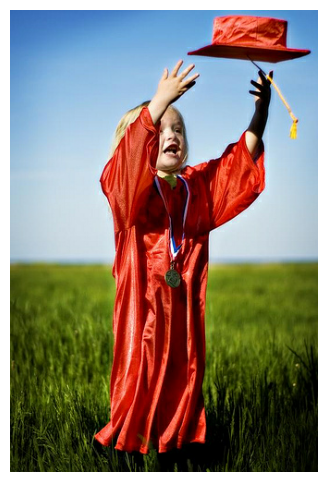

Image: 3553225222_f5ebe44af1.jpg

Ground-truth captions:
  1. A child in a graduation gown throws the cap in the air .
  2. A child who is celebrating their graduation in a field .
  3. A young child dressed in a graduation gown is throwing a graduation cap in the air .
  4. A young girl throws her graduation cap into the air .
  5. Young girl in red graduation suit flings her hat upward into the field .

Generated caption:
  → a young girl in a graduation gown throws the into the air




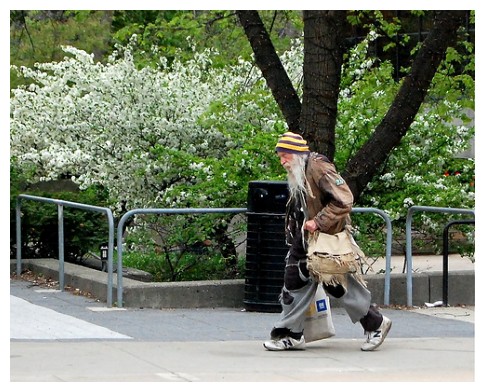

Image: 3508051251_82422717b3.jpg

Ground-truth captions:
  1. A homeless man is walking down the sidewalk alone .
  2. A man in worn and ragged clothes carries a satchel while passin a tree and trashcan .
  3. One old homeless guy walks by the park .
  4. The old man has a long white beard and a yellow and black hat .
  5. The old man with the white beard is walking down the street .

Generated caption:
  → a old man sits on a bench and walks by a park bench




Image: 2470486377_c3a39ccb7b.jpg

Ground-truth captions:
  1. A boy in a black shirt punches a yellow punching bag while a boy in a blue sweatshirt holds the bag .
  2. Many children playing outside in the grass practicing punching .
  3. Some kids play outside on a nice day .
  4. The boy in the black sweatshirt is hitting the yellow object held by the boy in the blue sweatshirt .
  5. Two boys talk on a field near palm trees .

Generated caption:
  → two boys talk on a field near a rival teams firing range




In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Paths & constants ---
IMAGE_FOLDER = "/kaggle/input/flickr8k/Images"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"
WEIGHTS_FILE = "image_captioning.h5"    # your saved model
NUM_SAMPLES  = 5                        # how many images to display

# --- 2) (Re)define your model & text vectorizer exactly as in training ---
#    e.g. class TokenAndPositionEmbedding, TransformerEncoder, TransformerDecoder,
#          ImageCaptioningModel, plus build cnn_encoder, instantiate
#    transformer_encoder, transformer_decoder, and then:
# caption_model = ImageCaptioningModel(cnn_encoder, transformer_encoder, transformer_decoder)
# caption_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))

#    Also make sure `vectorizer` and `max_len` (used during training) are in scope.

# --- 3) Load the best weights ---
caption_model.load_weights(WEIGHTS_FILE)
print(f"✅ Loaded weights from '{WEIGHTS_FILE}'")

# --- 4) Build ground-truth map from captions.txt ---
orig_caption_map = defaultdict(list)
with open(CAPTION_FILE, 'r') as f:
    lines = f.readlines()
if lines[0].lower().startswith("image"):
    lines = lines[1:]  # skip header

for line in lines:
    img_id, cap = line.strip().split(',', 1)
    orig_caption_map[img_id].append(cap.strip())

# --- 5) Define greedy decoder ---
def generate_caption(image_tensor):
    """
    Given a preprocessed image tensor (224×224×3),
    returns the generated caption string (without <start>/<end>).
    """
    # a) Encoder forward pass
    img_feat = caption_model.cnn_encoder(tf.expand_dims(image_tensor, 0), training=False)
    enc_out  = caption_model.transformer_encoder(img_feat, training=False)

    # b) Prepare start/end tokens
    start_id = vectorizer('<start>')[0].numpy().item()
    end_id   = vectorizer('<end>')[0].numpy().item()
    generated = [start_id]

    # c) Greedy decode up to max_len
    for _ in range(max_len):
        dec_input = tf.expand_dims(generated, 0)  # (1, seq_len)
        preds = caption_model.transformer_decoder(dec_input, enc_out, training=False)
        next_id = tf.argmax(preds[0, -1]).numpy().item()
        if next_id == end_id:
            break
        generated.append(next_id)

    # d) Convert IDs → words, skip the start token
    vocab = vectorizer.get_vocabulary()
    words = [vocab[i] for i in generated[1:]]
    return ' '.join(words)

# --- 6) Gather all image file paths ---
image_paths = [
    os.path.join(IMAGE_FOLDER, fname)
    for fname in os.listdir(IMAGE_FOLDER)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# --- 7) Sample & display ---
sample_paths = random.sample(image_paths, NUM_SAMPLES)

for img_path in sample_paths:
    img_id = os.path.basename(img_path)

    # a) Load & preprocess
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img_resized = tf.image.resize(img, (224, 224))
    img_pre = tf.keras.applications.vgg16.preprocess_input(img_resized)

    # b) Generate caption
    gen_cap = generate_caption(img_pre)

    # c) Display image
    plt.figure(figsize=(6,6))
    plt.imshow(tf.cast(img, tf.uint8))
    plt.axis('off')
    plt.show()

    # d) Print ground-truth captions
    print(f"Image: {img_id}\n")
    print("Ground-truth captions:")
    for i, ref in enumerate(orig_caption_map[img_id], 1):
        print(f"  {i}. {ref}")

    # e) Print the generated caption
    print(f"\nGenerated caption:\n  → {gen_cap}")
    print("\n" + "="*80 + "\n")


✅ Loaded weights from 'image_captioning.h5'


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Image: 3697379772_40d831392b.jpg

Ground-truth captions:
  1. a man playing a white guitar and singing as well
  2. a man plays his white guitar .
  3. A tattooed man in black playing a white guitar and singing .
  4. Man singing and playing a guitar .
  5. This guitarist is performing .

Generated caption:
  → a man plays his guitar on his head




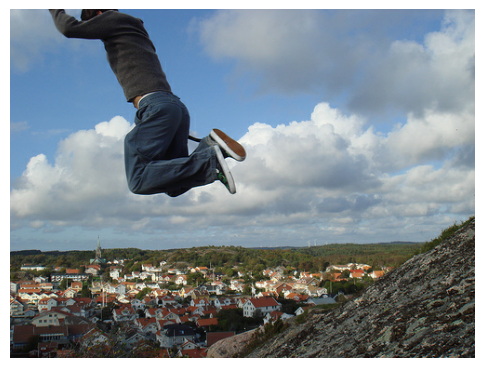

Image: 261737543_b8fdc24671.jpg

Ground-truth captions:
  1. A kid is jumping off the side of a mountain just outside a city .
  2. A man jumping on a hill overlooking a town .
  3. A man jumps off a cliff with a city view below .
  4. A man leaping from a rocky hill .
  5. A person jumping off of a high rock .

Generated caption:
  → a man in jeans is jumping off a hill overlooking a town




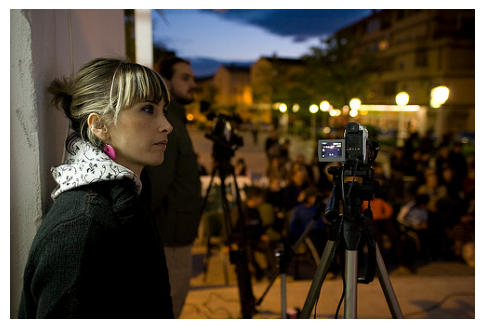

Image: 3259231890_16fe167b31.jpg

Ground-truth captions:
  1. A girl in black is starring off into the distance .
  2. A woman in a black coat with a camera on a tripod
  3. A woman leans against the wall while a camera operates next to her .
  4. A woman stands against a wall near a video camera .
  5. a woman stands behind a video camera .

Generated caption:
  → a woman stands against a wall near a video camera




Image: 2255266906_8222af18b9.jpg

Ground-truth captions:
  1. A bird sits in a leafless tree .
  2. A bird sits in a tree .
  3. a black bird sits in a dead tree .
  4. A black bird sitting in a leafless tree .
  5. A grey dove in a bare tree .

Generated caption:
  → a bird sits in a leafless tree




Image: 290982269_79fc9f36dc.jpg

Ground-truth captions:
  1. A female in blue jeans sitting with luggage against a wall
  2. A girl sits against a white wall with her belongings beside her .
  3. A woman sits against a wall in a fancy building .
  4. A woman with blond hair is sitting in a room or hallway with her luggage .
  5. A young blond woman rests next to some luggage .

Generated caption:
  → a young blond woman rests on a wall




In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) Paths & constants ---
IMAGE_FOLDER = "/kaggle/input/flickr8k/Images"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"
WEIGHTS_FILE = "image_captioning.h5"    # your saved model
NUM_SAMPLES  = 5                        # how many images to display

# --- 2) (Re)define your model & text vectorizer exactly as in training ---
#    e.g. class TokenAndPositionEmbedding, TransformerEncoder, TransformerDecoder,
#          ImageCaptioningModel, plus build cnn_encoder, instantiate
#    transformer_encoder, transformer_decoder, and then:
# caption_model = ImageCaptioningModel(cnn_encoder, transformer_encoder, transformer_decoder)
# caption_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))

#    Also make sure `vectorizer` and `max_len` (used during training) are in scope.

# --- 3) Load the best weights ---
caption_model.load_weights(WEIGHTS_FILE)
print(f"✅ Loaded weights from '{WEIGHTS_FILE}'")

# --- 4) Build ground-truth map from captions.txt ---
orig_caption_map = defaultdict(list)
with open(CAPTION_FILE, 'r') as f:
    lines = f.readlines()
if lines[0].lower().startswith("image"):
    lines = lines[1:]  # skip header

for line in lines:
    img_id, cap = line.strip().split(',', 1)
    orig_caption_map[img_id].append(cap.strip())

# --- 5) Define greedy decoder ---
def generate_caption(image_tensor):
    """
    Given a preprocessed image tensor (224×224×3),
    returns the generated caption string (without <start>/<end>).
    """
    # a) Encoder forward pass
    img_feat = caption_model.cnn_encoder(tf.expand_dims(image_tensor, 0), training=False)
    enc_out  = caption_model.transformer_encoder(img_feat, training=False)

    # b) Prepare start/end tokens
    start_id = vectorizer('<start>')[0].numpy().item()
    end_id   = vectorizer('<end>')[0].numpy().item()
    generated = [start_id]

    # c) Greedy decode up to max_len
    for _ in range(max_len):
        dec_input = tf.expand_dims(generated, 0)  # (1, seq_len)
        preds = caption_model.transformer_decoder(dec_input, enc_out, training=False)
        next_id = tf.argmax(preds[0, -1]).numpy().item()
        if next_id == end_id:
            break
        generated.append(next_id)

    # d) Convert IDs → words, skip the start token
    vocab = vectorizer.get_vocabulary()
    words = [vocab[i] for i in generated[1:]]
    return ' '.join(words)

# --- 6) Gather all image file paths ---
image_paths = [
    os.path.join(IMAGE_FOLDER, fname)
    for fname in os.listdir(IMAGE_FOLDER)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# --- 7) Sample & display ---
sample_paths = random.sample(image_paths, NUM_SAMPLES)

for img_path in sample_paths:
    img_id = os.path.basename(img_path)

    # a) Load & preprocess
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img_resized = tf.image.resize(img, (224, 224))
    img_pre = tf.keras.applications.vgg16.preprocess_input(img_resized)

    # b) Generate caption
    gen_cap = generate_caption(img_pre)

    # c) Display image
    plt.figure(figsize=(6,6))
    plt.imshow(tf.cast(img, tf.uint8))
    plt.axis('off')
    plt.show()

    # d) Print ground-truth captions
    print(f"Image: {img_id}\n")
    print("Ground-truth captions:")
    for i, ref in enumerate(orig_caption_map[img_id], 1):
        print(f"  {i}. {ref}")

    # e) Print the generated caption
    print(f"\nGenerated caption:\n  → {gen_cap}")
    print("\n" + "="*80 + "\n")


In [ ]:
# At the top of your notebook (or in a terminal):
!pip install git+https://github.com/salaniz/pycocoevalcap.git
!pip install nltk

import nltk
nltk.download('wordnet')


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-qctki6ta
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-qctki6ta
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=c6052a8b4c69162527bc08bb36a38b88b8a209ef45f94aaafba6e26e7a305f08
  Stored in directory: /tmp/pip-ephem-wheel-cache-n167w8hx/wheels/e5/d1/50/82763a91172a5c8058c9efff8692f3a41570e3ddd5b5b2c4b4
Successfully built pycocoevalcap


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# If you haven’t already:
# pip install git+https://github.com/salaniz/pycocoevalcap.git tqdm
# pip install nltk
# import nltk; nltk.download('wordnet')

import os
import random
import tensorflow as tf
from collections import defaultdict
from tqdm import tqdm

# COCO‐caption metrics
from pycocoevalcap.bleu.bleu     import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge   import Rouge
from pycocoevalcap.cider.cider   import Cider
from pycocoevalcap.spice.spice   import Spice

# --- PARAMETERS ---
# Only evaluate on one random image
NUM_EVAL = 50
eval_paths = random.sample(image_paths, min(NUM_EVAL, len(image_paths)))


# --- 2) Build refs & pre-compute hyps with progress bar ---
refs = {}
hyps = {}

print(f"Generating captions for {len(eval_paths)} images…")
for img_path in tqdm(eval_paths):
    img_id = os.path.basename(img_path)
    # skip if no GT
    if img_id not in orig_caption_map:
        continue

    # store ground truths
    refs[img_id] = orig_caption_map[img_id]

    # load & preprocess
    raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = tf.image.resize(img, (224, 224))
    img_pre = tf.keras.applications.vgg16.preprocess_input(img)

    # generate greedy caption
    hyps[img_id] = [ generate_caption(img_pre) ]

# --- 3) Set up scorers ---
scorers = [
    (Bleu(4),       ["BLEU-1","BLEU-2","BLEU-3","BLEU-4"]),
    (Meteor(),      "METEOR"),
    (Rouge(),       "ROUGE_L"),
    (Cider(),       "CIDEr"),
    (Spice(),       "SPICE")
]

# --- 4) Compute metrics ---
print("\nComputing metrics…")
final_scores = {}
for scorer, method in scorers:
    score, _ = scorer.compute_score(refs, hyps)
    if isinstance(method, list):
        for m, s in zip(method, score):
            final_scores[m] = s
    else:
        final_scores[method] = score

# --- 5) Display results ---
print("\n==== Evaluation (on subset) ====\n")
for metric, val in final_scores.items():
    print(f"{metric:8s}: {val:.4f}")


Generating captions for 50 images…


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
100%|██████████| 50/50 [00:25<00:00,  1.98it/s]



Computing metrics…
{'testlen': 513, 'reflen': 504, 'guess': [513, 463, 413, 363], 'correct': [424, 311, 213, 143]}
ratio: 1.0178571428551233

==== Evaluation (on subset) ====

BLEU-1  : 0.8265
BLEU-2  : 0.7451
BLEU-3  : 0.6591
BLEU-4  : 0.5795
METEOR  : 0.3969
ROUGE_L : 0.6461
CIDEr   : 1.7444
SPICE   : 0.3279
